# Stocks

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ig
import datetime as dt

## API Setup

In [2]:
details = ig.get_api('prod')
api = ig.APIHandler(details['url'], details['api_key'], details['user_name'], details['password'])
del details

In [5]:
api.debug_level = 0

## Price Analysis

### Historic Price Retrieval

In [4]:
# api.markets(93334)
# api.debug_level = 1
prices = api.prices('IX.D.FTSE.DAILY.IP', resolution='DAY',
                    from_date=dt.datetime(2020, 6, 1), to_date=dt.datetime.now(),
                    show_remaining_requests=True)

epic: IX.D.FTSE.DAILY.IP
from: 2020-06-01 00:00:00
to: 2020-08-19 23:52:45
https://api.ig.com/gateway/deal/prices/IX.D.FTSE.DAILY.IP/DAY/2020-06-01%2000%3A00%3A00/2020-08-19%2023%3A52%3A45
request: https://api.ig.com/gateway/deal/prices/IX.D.FTSE.DAILY.IP/DAY/2020-06-01%2000%3A00%3A00/2020-08-19%2023%3A52%3A45
page: 1
response: 200
[{'prices': [{'snapshotTime': '2020/06/01 00:00:00', 'openPrice': {'bid': 6064.1, 'ask': 6068.1, 'lastTraded': None}, 'closePrice': {'bid': 6178.0, 'ask': 6182.0, 'lastTraded': None}, 'highPrice': {'bid': 6203.0, 'ask': 6207.0, 'lastTraded': None}, 'lowPrice': {'bid': 6055.0, 'ask': 6059.0, 'lastTraded': None}, 'lastTradedVolume': 85302}, {'snapshotTime': '2020/06/02 00:00:00', 'openPrice': {'bid': 6177.5, 'ask': 6181.5, 'lastTraded': None}, 'closePrice': {'bid': 6234.2, 'ask': 6238.2, 'lastTraded': None}, 'highPrice': {'bid': 6240.6, 'ask': 6244.6, 'lastTraded': None}, 'lowPrice': {'bid': 6156.6, 'ask': 6159.7, 'lastTraded': None}, 'lastTradedVolume': 80237

### Data Manipulation

In [11]:
price_columns = [column for column in prices.columns if 'Price' in column]

for column in price_columns:
    new_columns = prices[column].apply(pd.Series)
    new_columns.columns = [column.replace('Price', '') + '_' + c for c in new_columns.columns]
    prices = prices.join(new_columns).drop(columns=column, axis=1)

,snapshotTime,lastTradedVolume,open_bid,open_ask,open_lastTraded,close_bid,close_ask,close_lastTraded,high_bid,high_ask,high_lastTraded,low_bid,low_ask,low_lastTraded
0,2020/08/13 09:00:00,5418,6213.8,6214.8,NaN,6214.0,6215.0,NaN,6217.5,6218.5,NaN,6198.3,6199.3,NaN
1,2020/08/13 10:00:00,4175,6213.8,6214.8,NaN,6219.0,6220.0,NaN,6225.8,6226.8,NaN,6212.5,6213.5,NaN
2,2020/08/13 11:00:00,4299,6218.8,6219.8,NaN,6207.3,6208.3,NaN,6227.3,6228.3,NaN,6205.3,6206.3,NaN
3,2020/08/13 12:00:00,3665,6207.5,6208.5,NaN,6214.5,6215.5,NaN,6217.0,6218.0,NaN,6206.0,6207.0,NaN
4,2020/08/13 13:00:00,4357,6214.2,6215.2,NaN,6216.5,6217.5,NaN,6219.5,6220.5,NaN,6203.5,6204.5,NaN
5,2020/08/13 14:00:00,10353,6216.0,6217.0,NaN,6197.7,6198.7,NaN,6217.7,6218.7,NaN,6188.5,6189.5,NaN
6,2020/08/13 15:00:00,8984,6197.5,6198.5,NaN,6191.6,6192.6,NaN,6200.8,6201.8,NaN,6187.6,6188.6,NaN
7,2020/08/13 16:00:00,14237,6191.8,6192.8,NaN,6185.3,6187.3,NaN,6198.3,6199.6,NaN,6180.6,6182.6,NaN
8,2020/08/13 17:00:00,1751,6185.6,6187.6,NaN,6191.1,6193.1,NaN,6193.3,6195.3,NaN,6185.1,6187.1,NaN
9,2020/08/13 18:00:00,1138,6191.3,6193.3,NaN,6186.6,6188.6,NaN,6193.3,6195.3,NaN,6177.8,6179.8,NaN


In [12]:
prices = (prices.rename(columns={'snapshotTime': 'time', 'lastTradedVolume': 'volume'})
          .dropna(axis=1)
         )
prices.time = pd.to_datetime(prices.time)
prices

,time,volume,open_bid,open_ask,close_bid,close_ask,high_bid,high_ask,low_bid,low_ask
0,2020-08-13 09:00:00,5418,6213.8,6214.8,6214.0,6215.0,6217.5,6218.5,6198.3,6199.3
1,2020-08-13 10:00:00,4175,6213.8,6214.8,6219.0,6220.0,6225.8,6226.8,6212.5,6213.5
2,2020-08-13 11:00:00,4299,6218.8,6219.8,6207.3,6208.3,6227.3,6228.3,6205.3,6206.3
3,2020-08-13 12:00:00,3665,6207.5,6208.5,6214.5,6215.5,6217.0,6218.0,6206.0,6207.0
4,2020-08-13 13:00:00,4357,6214.2,6215.2,6216.5,6217.5,6219.5,6220.5,6203.5,6204.5
5,2020-08-13 14:00:00,10353,6216.0,6217.0,6197.7,6198.7,6217.7,6218.7,6188.5,6189.5
6,2020-08-13 15:00:00,8984,6197.5,6198.5,6191.6,6192.6,6200.8,6201.8,6187.6,6188.6
7,2020-08-13 16:00:00,14237,6191.8,6192.8,6185.3,6187.3,6198.3,6199.6,6180.6,6182.6
8,2020-08-13 17:00:00,1751,6185.6,6187.6,6191.1,6193.1,6193.3,6195.3,6185.1,6187.1
9,2020-08-13 18:00:00,1138,6191.3,6193.3,6186.6,6188.6,6193.3,6195.3,6177.8,6179.8


In [7]:
price_cols = prices[[p for p in prices.columns if 'Price' in p]]
df = pd.DataFrame(index=price_cols.index)
for col in price_cols.columns:
    new_cols = price_cols[col].apply(pd.Series)
    new_cols.columns = [col.replace('Price', '') + '_' + new_col for new_col in new_cols.columns]
    df = df.join(new_cols, rsuffix='_' + col.replace('Price', ''))
df = df.join(prices[[p for p in prices.columns if 'Price' not in p]])
df

0     {'bid': 6213.8, 'ask': 6214.8, 'lastTraded': N...
1     {'bid': 6213.8, 'ask': 6214.8, 'lastTraded': N...
2     {'bid': 6218.8, 'ask': 6219.8, 'lastTraded': N...
3     {'bid': 6207.5, 'ask': 6208.5, 'lastTraded': N...
4     {'bid': 6214.2, 'ask': 6215.2, 'lastTraded': N...
5     {'bid': 6216.0, 'ask': 6217.0, 'lastTraded': N...
6     {'bid': 6197.5, 'ask': 6198.5, 'lastTraded': N...
7     {'bid': 6191.8, 'ask': 6192.8, 'lastTraded': N...
8     {'bid': 6185.6, 'ask': 6187.6, 'lastTraded': N...
9     {'bid': 6191.3, 'ask': 6193.3, 'lastTraded': N...
10    {'bid': 6186.8, 'ask': 6188.8, 'lastTraded': N...
11    {'bid': 6167.6, 'ask': 6169.6, 'lastTraded': N...
12    {'bid': 6178.3, 'ask': 6182.3, 'lastTraded': N...
13    {'bid': 6183.2, 'ask': 6187.2, 'lastTraded': N...
14    {'bid': 6182.8, 'ask': 6186.8, 'lastTraded': N...
15    {'bid': 6188.8, 'ask': 6192.8, 'lastTraded': N...
16    {'bid': 6187.6, 'ask': 6191.6, 'lastTraded': N...
17    {'bid': 6181.6, 'ask': 6184.6, 'lastTraded

,open_bid,open_ask,open_lastTraded,close_bid,close_ask,close_lastTraded,high_bid,high_ask,high_lastTraded,low_bid,low_ask,low_lastTraded,snapshotTime,lastTradedVolume
0,6213.8,6214.8,NaN,6214.0,6215.0,NaN,6217.5,6218.5,NaN,6198.3,6199.3,NaN,2020/08/13 09:00:00,5418
1,6213.8,6214.8,NaN,6219.0,6220.0,NaN,6225.8,6226.8,NaN,6212.5,6213.5,NaN,2020/08/13 10:00:00,4175
2,6218.8,6219.8,NaN,6207.3,6208.3,NaN,6227.3,6228.3,NaN,6205.3,6206.3,NaN,2020/08/13 11:00:00,4299
3,6207.5,6208.5,NaN,6214.5,6215.5,NaN,6217.0,6218.0,NaN,6206.0,6207.0,NaN,2020/08/13 12:00:00,3665
4,6214.2,6215.2,NaN,6216.5,6217.5,NaN,6219.5,6220.5,NaN,6203.5,6204.5,NaN,2020/08/13 13:00:00,4357
5,6216.0,6217.0,NaN,6197.7,6198.7,NaN,6217.7,6218.7,NaN,6188.5,6189.5,NaN,2020/08/13 14:00:00,10353
6,6197.5,6198.5,NaN,6191.6,6192.6,NaN,6200.8,6201.8,NaN,6187.6,6188.6,NaN,2020/08/13 15:00:00,8984
7,6191.8,6192.8,NaN,6185.3,6187.3,NaN,6198.3,6199.6,NaN,6180.6,6182.6,NaN,2020/08/13 16:00:00,14237
8,6185.6,6187.6,NaN,6191.1,6193.1,NaN,6193.3,6195.3,NaN,6185.1,6187.1,NaN,2020/08/13 17:00:00,1751
9,6191.3,6193.3,NaN,6186.6,6188.6,NaN,6193.3,6195.3,NaN,6177.8,6179.8,NaN,2020/08/13 18:00:00,1138


In [5]:
df = df.rename(columns={'snapshotTime': 'time', 'lastTradedVolume': 'volume'}).dropna(axis=1)
df.time = pd.to_datetime(df.time)

# df.time = pd.to_datetime(df.time)
df[df.time < dt.datetime(2020, 8, 14)]
col_list = df.columns.to_list()
time_idx = col_list.index('time')
new = ['time'] + col_list[:time_idx] + col_list[time_idx + 1:]
df = df[new]

### Analysis

In [16]:
prices[(prices.time.dt.weekday == 0) | (prices.time.dt.weekday == 4)]
prices.to_pickle('prices.pkl')

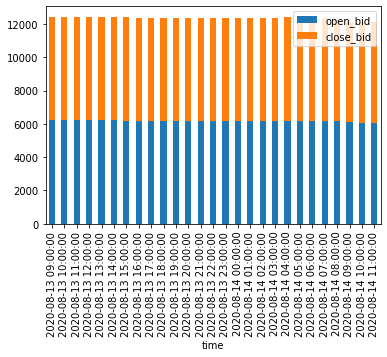

In [6]:
df.set_index('time')[['open_bid', 'close_bid']].plot.bar(stacked=True)